In [48]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots
include("../fourier_tensor_train.jl")
includet("../bp_fourier.jl");

In [49]:
seed = 2
rng = MersenneTwister(seed)

T = 100
N = 5
c = 3.0
gg = erdos_renyi(N, c/N; seed)
g = IndexedBiDiGraph(gg)

β = 1.0
h = 0.0
m⁰ = 0.2
K = 60

svd_trunc=TruncBond(6)
;

In [50]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5]

In [51]:
J = zeros(nv(g),nv(g))
for i in axes(J)[1], j in axes(J)[2]
    j>i && continue
    if has_edge(gg,i,j)
        J[i,j] = 2*rand(rng)-1
        J[j,i] = J[i,j]
    end
end

J

5×5 Matrix{Float64}:
 0.0        0.0        0.753632   0.310892   0.599153
 0.0        0.0       -0.482892  -0.299763   0.0
 0.753632  -0.482892   0.0       -0.426826  -0.240278
 0.310892  -0.299763  -0.426826   0.0        0.0
 0.599153   0.0       -0.240278   0.0        0.0

In [ ]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

w_fourier = [fill(GlauberFactor([J[ed.src,ed.dst] for ed in inedges(g,i)], h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [53]:
iters, cb_fourier = iterate_fourier!(bp_fourier,K, maxiter=50, σ=1/100; svd_trunc, tol=1e-6);

Running MPBP: iter 2    Time: 0:02:26

Running MPBP: iter 3    Time: 0:05:10

Running MPBP: iter 4    Time: 0:08:15

Running MPBP: iter 5    Time: 0:11:19

Running MPBP: iter 6    Time: 0:14:02

Running MPBP: iter 7    Time: 0:17:04

Running MPBP: iter 8    Time: 0:20:20

Running MPBP: iter 9    Time: 0:23:39

Running MPBP: iter 10    Time: 0:27:05

Running MPBP: iter 11    Time: 0:30:49

Running MPBP: iter 12    Time: 0:34:38

Running MPBP: iter 13    Time: 0:38:27

Running MPBP: iter 14    Time: 0:42:10

Running MPBP: iter 15    Time: 0:45:39

Running MPBP: iter 16    Time: 0:49:25

Running MPBP: iter 17    Time: 0:53:34

Running MPBP: iter 18    Time: 0:57:24

Running MPBP: iter 19    Time: 1:01:02

Running MPBP: iter 20    Time: 1:04:39

Running MPBP: iter 21    Time: 1:08:24

Running MPBP: iter 22    Time: 1:11:45

Running MPBP: iter 23    Time: 1:14:32

In [54]:
potts2spin(x, i; q=2) = (x-1)/(q-1)*2 - 1

i = 5
m_fourier = real.(means(potts2spin, bp_fourier))[i]
;

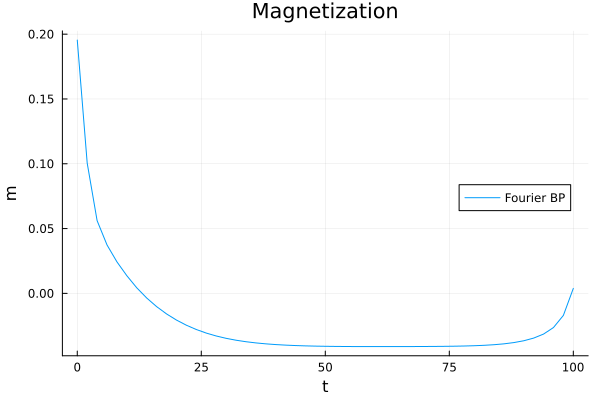

In [55]:
plot(0:2:T, m_fourier[1:2:end], label="Fourier BP", xlabel="t", ylabel="m", title="Magnetization", legend=:right)

In [56]:
using JLD2

m_fourier = real.(means(potts2spin, bp_fourier))
jldsave("random_coupling_er5_magnetization.jld2"; m_fourier)